# Cálculo de Evapotranspiração de Referência - Piracicaba

 

Este notebook implementa métodos clássicos de estimativa de evapotranspiração de referência (ET₀) para a estação de Piracicaba:



Métodos:

1. Penman-Monteith FAO-56 (referência)

2. Priestley-Taylor

3. Hargreaves & Samani

4. Thornthwaite

5. Thornthwaite-Camargo

6. Camargo



Principais variáveis disponíveis na planilha `Evapo_2.xlsx` (aba Piracicaba):

- Temperaturas: TMED (oC), TMAX (oC), TMIN (oC)

- Umidades relativas: UR MED, UR MAX, UR MIN

- Vento: Vento (m/s) (assumido média diária à altura da medição)

- Radiação global: Rad.Glob. (MJ/m2.d)

- Radiação líquida: Rad Liq (MJ/m2.d) (verificar se já representa Rn)

- Chuva (mm)

- Q_0: Radiação extraterrestre diária

- Variáveis derivadas: es_max, es_min, es (média), ea (pressão real de vapor), delta_e, s (declividade da curva de pressão de vapor)



Suposições e parâmetros:

- Altitude: 546 m (cabeçalho da estação) → pressão atmosférica padrão será calculada.

- Vento já está corrigido para 2 m (se não, aplicar ajuste FAO: u2 = u_z * (4.87 / ln(67.8 z - 5.42))).

- Fluxo de calor no solo G ≈ 0 para escala diária.

- Ano real dos dados: 2024 (INMET), usado para datas e dia juliano.



Próximos passos:

- Ler e limpar dados.

- Verificar consistência de radiação líquida.

- Calcular parâmetros astronômicos/dia juliano se necessário.

- Implementar funções de cada método.


In [24]:
# Leitura e limpeza inicial dos dados de Piracicaba
import pandas as pd, numpy as np, os, math

PATH = r'c:\Users\bruno\fisicambiental\Evapo_2.xlsx'
ALTITUDE_M = 546  # m
ANO = 2024  # ano real dos dados (INMET)

def pressao_atm_kPa(z_m: float) -> float:
    # Formula FAO-56 para pressão atmosférica padrão em função da altitude
    return 101.3 * ((293 - 0.0065 * z_m) / 293) ** 5.26

P_atm = pressao_atm_kPa(ALTITUDE_M)  # kPa

# Ler planilha
df = pd.read_excel(PATH, sheet_name='Piracicaba', skiprows=4)

# Renomear colunas chave para nomes simples
rename_map = {
    'DIA': 'dia',
    'TMED (oC)': 'tmed',
    'TMAX (oC)': 'tmax',
    'TMIN (oC)': 'tmin',
    'UR MED (%)': 'ur_med',
    'UR MAX (%)': 'ur_max',
    'UR MIN (%)': 'ur_min',
    'Vento (m/s)': 'vento_med',
    'Vel.Vento Max (m/s)': 'vento_max',
    'Chuva (mm)': 'chuva',
    'Rad.Glob. (MJ/m2.d)': 'rad_glob',
    'Rad Liq (MJ/m2.d)': 'rad_liq',
    'Q_0': 'Ra_extr',
    'es_max': 'es_max',
    'es_min': 'es_min',
    'es': 'es_med',
    'ea': 'ea',
    's': 's_slope'
}
df = df.rename(columns=rename_map)

# Construção robusta de mês, data e dia juliano
# 1) Se 'dia' > 31, tratamos como dia-do-ano (1..365/366)
# 2) Caso contrário, inferimos o mês a partir de coluna textual/numérica ou de reinícios do dia

is_doy = pd.to_numeric(df['dia'], errors='coerce').max() > 31

if is_doy:
    # Dia já é dia-do-ano
    df['dia'] = pd.to_numeric(df['dia'], errors='coerce').fillna(1).astype(int)
    df['data'] = pd.to_datetime(f"{ANO}-01-01") + pd.to_timedelta(df['dia'] - 1, unit='D')
    df['mes'] = df['data'].dt.month
    df['julia'] = df['data'].dt.dayofyear
else:
    # Tentar localizar coluna de mês textual/numérica
    mes_col = None
    month_names_pattern = r'Jan|Fev|Mar|Abr|Mai|Jun|Jul|Ago|Set|Out|Nov|Dez'
    possible_names = [m.lower() for m in ['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']]

    for c in df.columns:
        try:
            if isinstance(c, str) and c.strip().lower() in possible_names:
                mes_col = c
                break
        except Exception:
            continue

    if mes_col is None:
        for c in df.columns:
            try:
                if df[c].astype(str).str.contains(month_names_pattern, case=False, na=False).any():
                    mes_col = c
                    break
            except Exception:
                continue

    mes_map = {'Jan':1,'Fev':2,'Mar':3,'Abr':4,'Mai':5,'Jun':6,'Jul':7,'Ago':8,'Set':9,'Out':10,'Nov':11,'Dez':12}

    df['mes'] = np.nan
    if mes_col is not None:
        mapped = df[mes_col].astype(str).str.strip().map(lambda x: mes_map.get(x[:3].capitalize(), None) if isinstance(x, str) else None)
        numeric = pd.to_numeric(df[mes_col], errors='coerce')
        df['mes'] = mapped.fillna(numeric)

    # Fallback: detectar reinício do dia indicando troca de mês
    if df['mes'].isna().any():
        months = []
        current_month = 1
        prev_day = None
        for d in df['dia'].fillna(1).astype(int):
            if prev_day is None:
                months.append(current_month)
            else:
                if d < prev_day:
                    current_month += 1
                    if current_month > 12:
                        current_month = 1
                months.append(current_month)
            prev_day = d
        inferred = pd.Series(months, index=df.index)
        df['mes'] = df['mes'].fillna(inferred)

    df['mes'] = pd.to_numeric(df['mes'], errors='coerce').fillna(1).astype(int).clip(1,12)
    df['dia'] = pd.to_numeric(df['dia'], errors='coerce').fillna(1).astype(int)

    # Construir data a partir de mes/dia e derivar dia juliano pela própria datetime
    df['data'] = pd.to_datetime({'year': ANO, 'month': df['mes'], 'day': df['dia']})
    df['julia'] = df['data'].dt.dayofyear

# Interpolação simples para variáveis numéricas faltantes
numeric_cols = df.select_dtypes(include=['float','int']).columns
df[numeric_cols] = df[numeric_cols].interpolate(method='linear')

# Verificação radiação líquida
if 'rad_liq' in df.columns and 'rad_glob' in df.columns:
    ratio = (df['rad_liq'] / df['rad_glob']).describe()
    rad_liq_is_rn = ratio['mean'] < 1.0  # heurística simples
else:
    rad_liq_is_rn = False

# Calcular pressão de saturação e real se não existirem
def esat(T):
    return 0.6108 * np.exp((17.27 * T) / (T + 237.3))  # kPa

if 'es_max' not in df.columns or df['es_max'].isna().all():
    df['es_max'] = esat(df['tmax'])
if 'es_min' not in df.columns or df['es_min'].isna().all():
    df['es_min'] = esat(df['tmin'])
if 'es_med' not in df.columns or df['es_med'].isna().all():
    df['es_med'] = (df['es_max'] + df['es_min']) / 2
if 'ea' not in df.columns or df['ea'].isna().all():
    if 'ur_med' in df.columns:
        df['ea'] = df['es_med'] * df['ur_med'] / 100
    else:
        df['ea'] = df['es_med'] * 0.7  # fallback

# Declividade curva pressão vapor (Δ) se ausente
if 's_slope' not in df.columns or df['s_slope'].isna().all():
    df['s_slope'] = 4098 * (0.6108 * np.exp((17.27 * df['tmed']) / (df['tmed'] + 237.3))) / (df['tmed'] + 237.3) ** 2

# Psychrometric constant γ (kPa/°C)
gamma = 0.000665 * P_atm

print('Pressão atmosférica padrão (kPa):', round(P_atm,3))
print('Radiação líquida já considerada Rn?:', rad_liq_is_rn)
print('Linhas e colunas após limpeza:', df.shape)
df.head()

Pressão atmosférica padrão (kPa): 95.01
Radiação líquida já considerada Rn?: True
Linhas e colunas após limpeza: (366, 20)


,dia,tmed,ur_med,vento_med,tmax,ur_max,vento_max,tmin,ur_min,chuva,rad_glob,rad_liq,data,mes,julia,es_max,es_min,es_med,ea,s_slope
0,1,25.11,66.020625,2.068,32.71,84.6,5.792,19.76,39.02,0.000,23.25,12.29502,2024-01-01,1,1,4.94890,2.303767,3.626333,2.394128,0.189762
1,2,25.77,68.261667,1.571,32.85,94.2,6.911,19.71,41.69,0.000,21.49,11.09841,2024-01-02,1,2,4.98798,2.296633,3.642306,2.486299,0.196356
2,3,25.43,74.925630,1.456,33.67,92.2,6.032,20.28,44.81,0.254,23.15,12.69060,2024-01-03,1,3,5.22230,2.379119,3.800709,2.847705,0.192936
3,4,25.52,70.840520,2.226,32.71,90.7,8.430,20.91,40.70,0.000,23.49,11.74811,2024-01-04,1,4,4.94890,2.473290,3.711095,2.628959,0.193836
4,5,25.68,65.439170,2.147,33.67,93.1,7.390,19.23,34.37,0.000,26.75,13.08340,2024-01-05,1,5,5.22230,2.229122,3.725711,2.438074,0.195446


In [25]:
# Cálculo de parâmetros astronômicos, radiação e ET (PM, PT, HS)
import numpy as np

LAT_GRAUS = -22.7083  # 22°42'30" S em graus decimais negativo
ALBEDO = 0.23
ALPHA_PT = 1.26
G_DIARIO = 0.0  # MJ m-2 d-1 (fluxo de calor no solo diário)

# Funções auxiliares
RAD2DEG = 180/np.pi
DEG2RAD = np.pi/180

def ra_extraterrestre(juliano: int, lat_rad: float) -> float:
    # Ra (MJ m-2 d-1) FAO-56 eq. 21
    dr = 1 + 0.033 * np.cos(2 * np.pi / 365 * juliano)
    delta = 0.409 * np.sin(2 * np.pi / 365 * juliano - 1.39)
    ws = np.arccos(-np.tan(lat_rad) * np.tan(delta))
    Ra = (24 * 60 / np.pi) * 0.0820 * dr * (ws * np.sin(lat_rad) * np.sin(delta) + np.cos(lat_rad) * np.cos(delta) * np.sin(ws))
    return Ra

def rso_clear_sky(Ra: float, z_m: float) -> float:
    # Rso (MJ m-2 d-1) FAO-56 eq. 37 (z < 1000 m)
    return (0.75 + 2e-5 * z_m) * Ra

def net_longwave(Rs: float, Rso: float, tmax: float, tmin: float, ea: float) -> float:
    # Rnl (MJ m-2 d-1) FAO-56 eq. 39
    tmaxK = tmax + 273.16
    tminK = tmin + 273.16
    sigma = 4.903e-9  # MJ K-4 m-2 d-1
    term_temp = (tmaxK**4 + tminK**4) / 2
    term_cloud = 1.35 * (Rs / Rso) - 0.35 if Rso > 0 else 0
    Rnl = sigma * term_temp * (0.34 - 0.14 * np.sqrt(ea)) * term_cloud
    return Rnl

def penman_monteith(Rn: float, T: float, u2: float, es: float, ea: float, delta: float, gamma: float, G: float = 0.0) -> float:
    # ET0 (mm d-1) FAO-56 eq. 6
    num = 0.408 * delta * (Rn - G) + gamma * (900/(T+273)) * u2 * (es - ea)
    den = delta + gamma * (1 + 0.34 * u2)
    return num / den if den != 0 else np.nan

def priestley_taylor(Rn: float, delta: float, gamma: float, alpha: float = ALPHA_PT, G: float = 0.0) -> float:
    return alpha * (delta / (delta + gamma)) * 0.408 * (Rn - G)

def hargreaves_samani(Tmean: float, Tmax: float, Tmin: float, Ra: float) -> float:
    # Ra em MJ m-2 d-1 conforme eq. HS original
    return 0.0023 * (Tmean + 17.8) * np.sqrt(max(Tmax - Tmin, 0)) * Ra

lat_rad = LAT_GRAUS * DEG2RAD

# Se não existir Ra_extr (Q_0), recalcular; senão usar
if 'Ra_extr' not in df.columns or df['Ra_extr'].isna().all():
    df['Ra_extr'] = df['julia'].apply(lambda j: ra_extraterrestre(int(j), lat_rad))

# Calcular Rn: usar rad_liq se disponível e plausível, senão estimar de Rs
if 'rad_liq' in df.columns and not df['rad_liq'].isna().all():
    # Verificar razão média
    ratio_mean = (df['rad_liq']/df['rad_glob']).replace([np.inf,-np.inf], np.nan).mean()
    usar_rad_liq = ratio_mean < 1.2  # heurística
else:
    usar_rad_liq = False

Rn_list = []
for i, row in df.iterrows():
    Rs = row.get('rad_glob', np.nan)
    tmax = row.get('tmax', np.nan)
    tmin = row.get('tmin', np.nan)
    ea = row.get('ea', np.nan)
    Ra = row.get('Ra_extr', np.nan)
    if usar_rad_liq:
        Rn = row.get('rad_liq', np.nan)
    else:
        Rns = (1 - ALBEDO) * Rs
        Rso = rso_clear_sky(Ra, ALTITUDE_M)
        Rnl = net_longwave(Rs, Rso, tmax, tmin, ea)
        Rn = Rns - Rnl
    Rn_list.append(Rn)

df['Rn'] = Rn_list

# Cálculo ET Penman-Monteith, Priestley-Taylor e Hargreaves-Samani
if 's_slope' in df.columns:
    delta_col = df['s_slope']
else:
    delta_col = 4098 * (0.6108 * np.exp((17.27 * df['tmed']) / (df['tmed'] + 237.3))) / (df['tmed'] + 237.3) ** 2

# Psychrometric constant gamma já calculada na célula anterior (gamma); garantir fallback
try:
    gamma
except NameError:
    gamma = 0.000665 * pressao_atm_kPa(ALTITUDE_M)

u2 = df.get('vento_med', pd.Series(np.full(len(df), 2.0)))  # se faltar, usar 2 m/s

ET_PM = []
ET_PT = []
ET_HS = []
for i, row in df.iterrows():
    Rn = row['Rn']
    T = row['tmed']
    es = row['es_med']
    ea = row['ea']
    delta = delta_col.iloc[i]
    wind = u2.iloc[i]
    Ra = row['Ra_extr']
    et_pm = penman_monteith(Rn, T, wind, es, ea, delta, gamma, G_DIARIO)
    et_pt = priestley_taylor(Rn, delta, gamma, ALPHA_PT, G_DIARIO)
    et_hs = hargreaves_samani(T, row['tmax'], row['tmin'], Ra)
    ET_PM.append(et_pm)
    ET_PT.append(et_pt)
    ET_HS.append(et_hs)

df['ET_PM'] = ET_PM

df['ET_PT'] = ET_PT
df['ET_HS'] = ET_HS

print('Resumo ET (mm/d):')
print(df[['ET_PM','ET_PT','ET_HS']].describe())

df.head()

Resumo ET (mm/d):
            ET_PM       ET_PT       ET_HS
count  366.000000  366.000000  366.000000
mean     3.257760    3.273488   11.629347
std      1.364735    1.511133    3.181388
min     -0.057852   -0.498019    2.554697
25%      2.277346    2.122261    8.856634
50%      3.339776    3.168156   11.750171
75%      4.258035    4.299348   14.260976
max      6.868778    6.651928   18.177315


,dia,tmed,ur_med,vento_med,tmax,ur_max,vento_max,tmin,ur_min,chuva,...,es_max,es_min,es_med,ea,s_slope,Ra_extr,Rn,ET_PM,ET_PT,ET_HS
0,1,25.11,66.020625,2.068,32.71,84.6,5.792,19.76,39.02,0.000,...,4.94890,2.303767,3.626333,2.394128,0.189762,42.685727,12.29502,4.835682,4.741823,15.160165
1,2,25.77,68.261667,1.571,32.85,94.2,6.911,19.71,41.69,0.000,...,4.98798,2.296633,3.642306,2.486299,0.196356,42.670095,11.09841,4.210153,4.316534,15.500178
2,3,25.43,74.925630,1.456,33.67,92.2,6.032,20.28,44.81,0.254,...,5.22230,2.379119,3.800709,2.847705,0.192936,42.652747,12.69060,4.395927,4.914578,15.518522
3,4,25.52,70.840520,2.226,32.71,90.7,8.430,20.91,40.70,0.000,...,4.94890,2.473290,3.711095,2.628959,0.193836,42.633670,11.74811,4.553091,4.554808,14.591838
4,5,25.68,65.439170,2.147,33.67,93.1,7.390,19.23,34.37,0.000,...,5.22230,2.229122,3.725711,2.438074,0.195446,42.612849,13.08340,5.150532,5.082797,16.193530


In [26]:
# Thornthwaite mensal (ajuste apenas pelo número de dias)
import numpy as np
import calendar

# Recriar dicionário de dias por mês (ajustado conforme o ano)
feb_days = 29 if calendar.isleap(ANO) else 28
dias_mes = {1:31, 2:feb_days, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
# (opcional) manter compatibilidade com verificação anterior
if ANO == 2024:
    dias_mes[2] = 29

# Temperatura média mensal
T_mensal = df.groupby('mes')['tmed'].mean()

# Índice de calor mensal (apenas T>0)
I_m = ((T_mensal/5).clip(lower=0)) ** 1.514
I = I_m.sum()

# Expoente a
a = 6.75e-7 * I**3 - 7.71e-5 * I**2 + 1.792e-2 * I + 0.49239

# ET mensal básica (mm/mês)
ET_m_base = 16 * (10 * T_mensal / I) ** a
ET_m_base[T_mensal <= 0] = 0

# Ajuste apenas pelo número de dias do mês
ajuste_dias = pd.Series({m: dias_mes[m]/30.0 for m in dias_mes})
ET_m_ajustada = ET_m_base * ajuste_dias

# Distribuição diária (média diária do mês)
ET_m_diaria = ET_m_ajustada / pd.Series(dias_mes)

# Mapear para cada linha diária
df['ET_TH'] = df['mes'].map(ET_m_diaria)

print('Índice calor anual I:', round(I,3))
print('Expoente a:', round(a,4))
print('\nResumo ET Thornthwaite (mm/mês):')
print(ET_m_ajustada.describe())
print('\nPrimeiros valores diários atribuídos:')
print(df[['mes','dia','ET_TH']].head())

df.head()

Índice calor anual I: 122.184
Expoente a: 2.7622

Resumo ET Thornthwaite (mm/mês):
count     12.000000
mean      96.373200
std       23.702023
min       53.091803
25%       80.163551
50%      108.710739
75%      113.389530
max      118.787095
dtype: float64

Primeiros valores diários atribuídos:
   mes  dia     ET_TH
0    1    1  3.831842
1    1    2  3.831842
2    1    3  3.831842
3    1    4  3.831842
4    1    5  3.831842


,dia,tmed,ur_med,vento_med,tmax,ur_max,vento_max,tmin,ur_min,chuva,...,es_min,es_med,ea,s_slope,Ra_extr,Rn,ET_PM,ET_PT,ET_HS,ET_TH
0,1,25.11,66.020625,2.068,32.71,84.6,5.792,19.76,39.02,0.000,...,2.303767,3.626333,2.394128,0.189762,42.685727,12.29502,4.835682,4.741823,15.160165,3.831842
1,2,25.77,68.261667,1.571,32.85,94.2,6.911,19.71,41.69,0.000,...,2.296633,3.642306,2.486299,0.196356,42.670095,11.09841,4.210153,4.316534,15.500178,3.831842
2,3,25.43,74.925630,1.456,33.67,92.2,6.032,20.28,44.81,0.254,...,2.379119,3.800709,2.847705,0.192936,42.652747,12.69060,4.395927,4.914578,15.518522,3.831842
3,4,25.52,70.840520,2.226,32.71,90.7,8.430,20.91,40.70,0.000,...,2.473290,3.711095,2.628959,0.193836,42.633670,11.74811,4.553091,4.554808,14.591838,3.831842
4,5,25.68,65.439170,2.147,33.67,93.1,7.390,19.23,34.37,0.000,...,2.229122,3.725711,2.438074,0.195446,42.612849,13.08340,5.150532,5.082797,16.193530,3.831842


In [27]:
# Somatórios anuais (Thornthwaite) e implementação Thornthwaite-Camargo (com correção por horas de luz)
import calendar

# 1) Somatório anual Thornthwaite (com ajuste de dias já feito na célula anterior)
#    Aqui usamos a coluna diária ET_TH e integramos por mês e ano.
if 'ET_TH' in df.columns:
    th_mensal_soma = df.groupby('mes')['ET_TH'].sum()
    th_anual = th_mensal_soma.sum()
else:
    th_mensal_soma = None
    th_anual = np.nan

print('Thornthwaite (ajuste dias) - soma mensal (mm):')
print(th_mensal_soma if th_mensal_soma is not None else 'ET_TH não encontrado')
print('Thornthwaite (ajuste dias) - soma anual (mm):', round(float(th_anual), 1))

# 2) Thornthwaite-Camargo: ETm_base * (d/30) * (N/12), onde N = horas médias de luz do mês
#    Recalcular base (I, a, ET_m_base) para independência desta célula
feb_days = 29 if calendar.isleap(ANO) else 28
dias_mes = {1:31, 2:feb_days, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}

T_mensal = df.groupby('mes')['tmed'].mean()
I_m = ((T_mensal/5).clip(lower=0)) ** 1.514
I = I_m.sum()
a = 6.75e-7 * I**3 - 7.71e-5 * I**2 + 1.792e-2 * I + 0.49239
ET_m_base = 16 * (10 * T_mensal / I) ** a
ET_m_base[T_mensal <= 0] = 0

# Horas de luz diárias para cada dia (N = 24/pi * ws)
DEG2RAD = np.pi/180
LAT_GRAUS = -22.7083
lat_rad = LAT_GRAUS * DEG2RAD

def ws_por_dia(juliano:int, lat_rad:float) -> float:
    delta = 0.409 * np.sin(2 * np.pi / 365 * juliano - 1.39)
    # limitar argumento numérico do arccos ao intervalo [-1,1]
    arg = -np.tan(lat_rad) * np.tan(delta)
    arg = np.clip(arg, -1.0, 1.0)
    return np.arccos(arg)

ws_daily = df['julia'].apply(lambda j: ws_por_dia(int(j), lat_rad))
N_daily = (24/np.pi) * ws_daily
N_medio = N_daily.groupby(df['mes']).mean()

# ET mensal Thornthwaite-Camargo com (d/30)*(N/12)
ajuste_dias = pd.Series({m: dias_mes[m]/30.0 for m in dias_mes})
ajuste_horas = (N_medio / 12.0)

# alinhar índices
ajuste_horas = ajuste_horas.reindex(ET_m_base.index).ffill()
ET_m_TC = ET_m_base * ajuste_dias.reindex(ET_m_base.index) * ajuste_horas

# Média diária por mês (para mapear ao diário)
ET_diaria_TC = ET_m_TC / pd.Series(dias_mes)

df['ET_THC'] = df['mes'].map(ET_diaria_TC)

# Relatórios
thc_mensal_soma = df.groupby('mes')['ET_THC'].sum()
thc_anual = thc_mensal_soma.sum()

print('\nThornthwaite-Camargo - soma mensal (mm):')
print(thc_mensal_soma)
print('Thornthwaite-Camargo - soma anual (mm):', round(float(thc_anual), 1))

print('\nResumo final (mm/ano):')
print('TH (dias apenas):', round(float(th_anual), 1))
print('TH-Camargo:', round(float(thc_anual), 1))

df.head()

Thornthwaite (ajuste dias) - soma mensal (mm):
mes
1     118.787095
2     113.898130
3     117.299822
4     110.419172
5      85.607924
6      63.666493
7      53.091803
8      63.830431
9     113.219997
10    107.002305
11     98.612780
12    111.042448
Name: ET_TH, dtype: float64
Thornthwaite (ajuste dias) - soma anual (mm): 1156.5

Thornthwaite-Camargo - soma mensal (mm):
mes
1     130.864150
2     120.966851
3     118.335578
4     105.241749
5      77.678915
6      56.390558
7      47.669205
8      59.925537
9     112.430245
10    112.201762
11    107.868479
12    123.738674
Name: ET_THC, dtype: float64
Thornthwaite-Camargo - soma anual (mm): 1173.3

Resumo final (mm/ano):
TH (dias apenas): 1156.5
TH-Camargo: 1173.3


,dia,tmed,ur_med,vento_med,tmax,ur_max,vento_max,tmin,ur_min,chuva,...,es_med,ea,s_slope,Ra_extr,Rn,ET_PM,ET_PT,ET_HS,ET_TH,ET_THC
0,1,25.11,66.020625,2.068,32.71,84.6,5.792,19.76,39.02,0.000,...,3.626333,2.394128,0.189762,42.685727,12.29502,4.835682,4.741823,15.160165,3.831842,4.221424
1,2,25.77,68.261667,1.571,32.85,94.2,6.911,19.71,41.69,0.000,...,3.642306,2.486299,0.196356,42.670095,11.09841,4.210153,4.316534,15.500178,3.831842,4.221424
2,3,25.43,74.925630,1.456,33.67,92.2,6.032,20.28,44.81,0.254,...,3.800709,2.847705,0.192936,42.652747,12.69060,4.395927,4.914578,15.518522,3.831842,4.221424
3,4,25.52,70.840520,2.226,32.71,90.7,8.430,20.91,40.70,0.000,...,3.711095,2.628959,0.193836,42.633670,11.74811,4.553091,4.554808,14.591838,3.831842,4.221424
4,5,25.68,65.439170,2.147,33.67,93.1,7.390,19.23,34.37,0.000,...,3.725711,2.438074,0.195446,42.612849,13.08340,5.150532,5.082797,16.193530,3.831842,4.221424


In [28]:
# Método Camargo e consolidação final das séries de ET
import numpy as np

# Camargo: ET_CAM = K * Rs * (Tmed + 20)
# Referência empírica brasileira; aqui usamos Rs em MJ m-2 d-1 e K=0.01 para obter mm d-1
K_CAMARGO = 0.01
if 'rad_glob' in df.columns:
    df['ET_CAM'] = K_CAMARGO * df['rad_glob'] * (df['tmed'] + 20)
else:
    # fallback para Ra_extr se Rs não existir (menos recomendado)
    df['ET_CAM'] = K_CAMARGO * df['Ra_extr'] * (df['tmed'] + 20)

# Somatórios mensais e anuais de todos os métodos implementados
cols = [c for c in ['ET_PM','ET_PT','ET_HS','ET_TH','ET_THC','ET_CAM'] if c in df.columns]
mensal = df.groupby('mes')[cols].sum()
anual = mensal.sum(axis=0)

print('Somas mensais por método (mm/mês):')
print(mensal.round(2))
print('\nSomas anuais por método (mm/ano):')
print(anual.round(1))

# DataFrame consolidado básico
colunas_final = ['data','mes','dia'] + cols
et_df = df[colunas_final].copy()
print('\nPrévia do DataFrame final:')
print(et_df.head())

# (Opcional) salvar CSV consolidado
# et_df.to_csv('Piracicaba_ET_2024.csv', index=False)

et_df.head()

Somas mensais por método (mm/mês):
      ET_PM   ET_PT   ET_HS   ET_TH  ET_THC  ET_CAM
mes                                                
1    127.08  137.32  454.27  118.79  130.86  315.76
2    107.10  122.77  386.18  113.90  120.97  271.57
3    102.16  115.46  354.86  117.30  118.34  263.43
4     95.21  105.95  310.30  110.42  105.24  226.82
5     82.89   81.26  271.21   85.61   77.68  190.34
6     65.19   57.56  243.03   63.67   56.39  166.36
7     58.33   54.55  239.03   53.09   47.67  153.61
8     96.71   79.69  322.29   63.83   59.93  209.09
9    124.33   95.11  417.54  113.22  112.43  254.74
10   114.71  101.75  427.89  107.00  112.20  265.28
11   105.99  117.79  400.72   98.61  107.87  272.61
12   112.64  128.89  429.02  111.04  123.74  287.75

Somas anuais por método (mm/ano):
ET_PM     1192.3
ET_PT     1198.1
ET_HS     4256.3
ET_TH     1156.5
ET_THC    1173.3
ET_CAM    2877.4
dtype: float64

Prévia do DataFrame final:
        data  mes  dia     ET_PM     ET_PT      ET_HS    

,data,mes,dia,ET_PM,ET_PT,ET_HS,ET_TH,ET_THC,ET_CAM
0,2024-01-01,1,1,4.835682,4.741823,15.160165,3.831842,4.221424,10.488075
1,2024-01-02,1,2,4.210153,4.316534,15.500178,3.831842,4.221424,9.835973
2,2024-01-03,1,3,4.395927,4.914578,15.518522,3.831842,4.221424,10.517045
3,2024-01-04,1,4,4.553091,4.554808,14.591838,3.831842,4.221424,10.692648
4,2024-01-05,1,5,5.150532,5.082797,16.193530,3.831842,4.221424,12.219400


# Validação e comparação dos métodos (2024)

Nesta seção, comparamos cada método com `ET_PM` (referência FAO-56):

- Métricas: n, viés (método−PM), MAE, RMSE, r, R², NSE, inclinação (ajuste linear).
- Séries diárias: média móvel 7 dias para melhor leitura.
- Dispersões: cada método vs `ET_PM` com linha 1:1.

Observações: valores NaN são ignorados nas métricas; meses foram inferidos a partir dos dados.


Métricas diárias (vs ET_PM):
          n   bias    MAE   RMSE      r     R2     NSE  slope  d_willmott
metodo                                                                   
ET_PT   366  0.016  0.461  0.614  0.914  0.835   0.797  1.012       0.953
ET_TH   366 -0.098  0.980  1.252  0.423  0.179   0.156  0.236       0.592
ET_THC  366 -0.052  0.990  1.269  0.439  0.193   0.133  0.299       0.648
ET_CAM  366  4.604  4.618  4.914  0.935  0.874 -12.000  2.005       0.430
ET_HS   366  8.372  8.372  8.649  0.834  0.696 -39.276  1.945       0.257


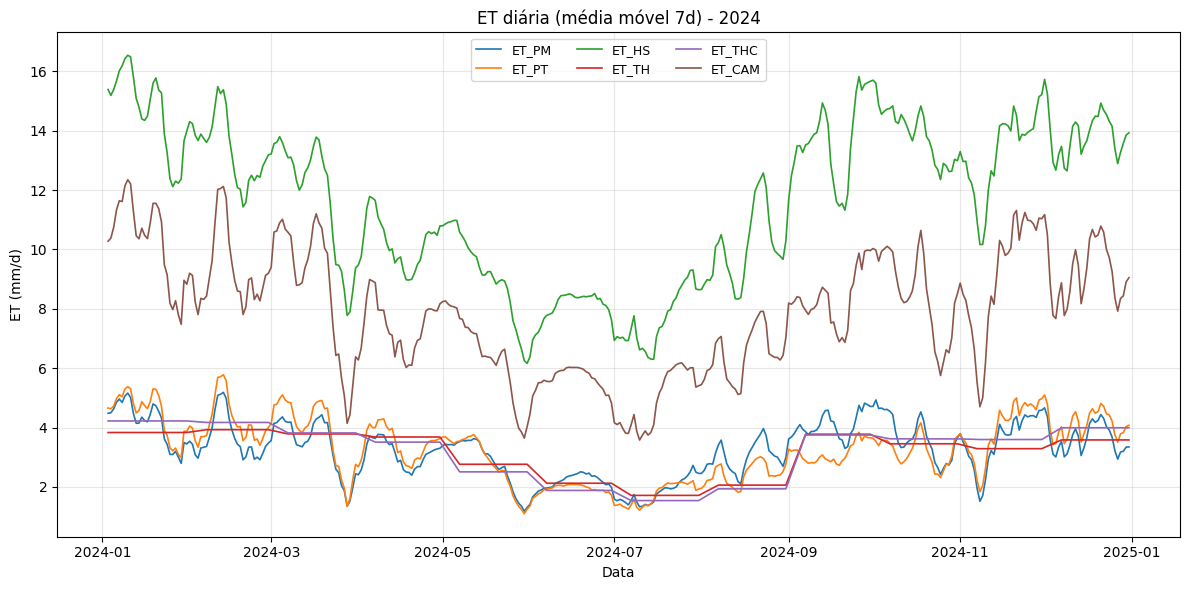

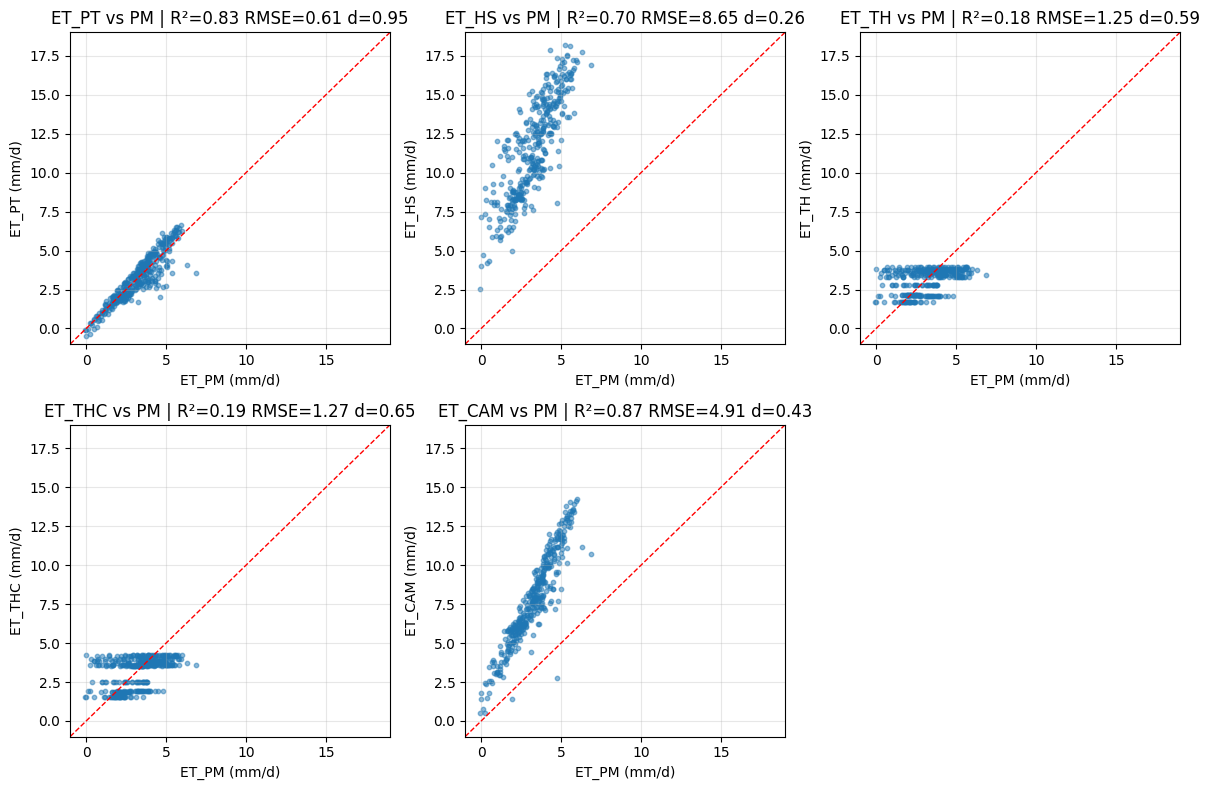

In [31]:
# Métricas diárias e gráficos de séries e dispersão (inclui d de Willmott e exportação 600 dpi)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Garantir que as colunas necessárias existem
disponiveis = [c for c in ['ET_PM','ET_PT','ET_HS','ET_TH','ET_THC','ET_CAM'] if c in df.columns]
ref = 'ET_PM'
metodos = [c for c in disponiveis if c != ref]

if ref not in disponiveis or len(metodos) == 0:
    raise RuntimeError('Colunas de ET insuficientes para validação. Verifique etapas anteriores.')

# Função de métricas com d de Willmott
def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    n = int(mask.sum())
    if n < 3:
        return {'n': n, 'bias': np.nan, 'MAE': np.nan, 'RMSE': np.nan, 'r': np.nan, 'R2': np.nan, 'NSE': np.nan, 'slope': np.nan, 'd_willmott': np.nan}
    yt = y_true[mask]
    yp = y_pred[mask]
    diff = yp - yt
    bias = float(np.mean(diff))
    mae = float(np.mean(np.abs(diff)))
    rmse = float(np.sqrt(np.mean(diff**2)))
    r = float(np.corrcoef(yt, yp)[0,1]) if np.std(yt) > 0 and np.std(yp) > 0 else np.nan
    R2 = r**2 if np.isfinite(r) else np.nan
    denom = np.sum((yt - np.mean(yt))**2)
    NSE = float(1 - np.sum((diff)**2) / denom) if denom > 0 else np.nan
    # inclinação ajuste linear yp = a*yt + b
    try:
        slope = float(np.polyfit(yt, yp, 1)[0])
    except Exception:
        slope = np.nan
    # índice de concordância de Willmott (1981)
    yt_mean = np.mean(yt)
    will_den = np.sum((np.abs(yp - yt_mean) + np.abs(yt - yt_mean))**2)
    will_num = np.sum((yp - yt)**2)
    d_willmott = float(1 - will_num / will_den) if will_den > 0 else np.nan
    return {'n': n, 'bias': bias, 'MAE': mae, 'RMSE': rmse, 'r': r, 'R2': R2, 'NSE': NSE, 'slope': slope, 'd_willmott': d_willmott}

# Métricas diárias por método
linhas = []
y = df[ref].to_numpy()
for m in metodos:
    x = df[m].to_numpy()
    met = compute_metrics(y, x)
    met['metodo'] = m
    linhas.append(met)
metrics_daily = pd.DataFrame(linhas).set_index('metodo').sort_values('RMSE')
print('Métricas diárias (vs ET_PM):')
print(metrics_daily.round(3))

# Salvar métricas diárias em CSV
metrics_daily.round(5).to_csv('metrics_diarias_ET_2024.csv')

# Séries temporais (média móvel 7 dias)
plot_cols = [ref] + metodos
serie = df[['data'] + plot_cols].dropna(subset=['data']).copy()
serie = serie.sort_values('data').set_index('data')
roll = serie.rolling(window=7, min_periods=3).mean()

plt.figure(figsize=(12,6))
for c in plot_cols:
    plt.plot(roll.index, roll[c], label=c, linewidth=1.2)
plt.title('ET diária (média móvel 7d) - 2024')
plt.xlabel('Data')
plt.ylabel('ET (mm/d)')
plt.grid(True, alpha=0.3)
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.savefig('ET_series_7d_2024.png', dpi=600)
plt.show()

# Dispersões vs ET_PM com linha 1:1
n_methods = len(metodos)
rows = 2
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(12,8))
axes = axes.flatten()

vals = np.concatenate([serie[ref].values] + [serie[m].values for m in metodos])
fmin = np.nanmin(vals)
fmax = np.nanmax(vals)
lim_min = float(np.floor(fmin))
lim_max = float(np.ceil(fmax))

for i, m in enumerate(metodos):
    ax = axes[i]
    mask = np.isfinite(serie[ref]) & np.isfinite(serie[m])
    ax.scatter(serie[ref][mask], serie[m][mask], s=10, alpha=0.5)
    ax.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', linewidth=1)
    r2 = metrics_daily.loc[m, 'R2'] if m in metrics_daily.index else np.nan
    rmse = metrics_daily.loc[m, 'RMSE'] if m in metrics_daily.index else np.nan
    d_w = metrics_daily.loc[m, 'd_willmott'] if m in metrics_daily.index else np.nan
    ax.set_title(f"{m} vs PM | R²={r2:.2f} RMSE={rmse:.2f} d={d_w:.2f}")
    ax.set_xlabel('ET_PM (mm/d)')
    ax.set_ylabel(f'{m} (mm/d)')
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.grid(True, alpha=0.3)

for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()
fig.savefig('ET_scatter_2024.png', dpi=600)
plt.show()

Métricas mensais (somas por mês) vs ET_PM:
         n     bias      MAE     RMSE      r     R2  d_willmott
metodo                                                         
ET_TH   12   -2.988    9.631   12.692  0.842  0.709       0.908
ET_THC  12   -1.586   11.057   14.184  0.875  0.765       0.909
ET_PT   12    0.480   12.518   14.236  0.835  0.698       0.900
ET_CAM  12  140.419  140.419  143.636  0.927  0.860       0.224
ET_HS   12  255.333  255.333  260.881  0.958  0.917       0.136

Totais anuais (mm/ano):
ET_PM     1192.3
ET_PT     1198.1
ET_HS     4256.3
ET_TH     1156.5
ET_THC    1173.3
ET_CAM    2877.4
dtype: float64


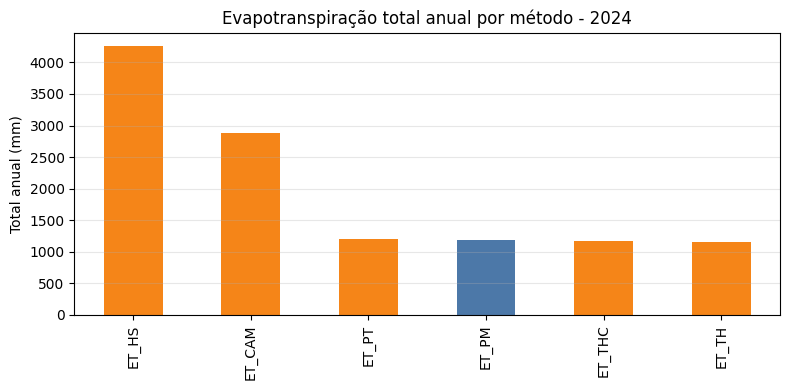

In [32]:
# Métricas mensais e totais anuais (inclui d de Willmott) + exportação 600 dpi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ref = 'ET_PM'
metodos = [c for c in ['ET_PT','ET_HS','ET_TH','ET_THC','ET_CAM'] if c in df.columns]
cols = [ref] + metodos

# Somas mensais
tab_mensal = df.groupby('mes')[cols].sum().sort_index()

# Função Willmott mensal
def metrics_month(Y, X):
    mask = np.isfinite(Y) & np.isfinite(X)
    if mask.sum() < 3:
        return {'n': int(mask.sum()), 'bias': np.nan, 'MAE': np.nan, 'RMSE': np.nan, 'r': np.nan, 'R2': np.nan, 'd_willmott': np.nan}
    yt = Y[mask]; yp = X[mask]
    diff = yp - yt
    bias = float(np.mean(diff))
    mae = float(np.mean(np.abs(diff)))
    rmse = float(np.sqrt(np.mean(diff**2)))
    r = float(np.corrcoef(yt, yp)[0,1]) if np.std(yt)>0 and np.std(yp)>0 else np.nan
    R2 = r**2 if np.isfinite(r) else np.nan
    yt_mean = np.mean(yt)
    will_den = np.sum((np.abs(yp - yt_mean) + np.abs(yt - yt_mean))**2)
    will_num = np.sum((yp - yt)**2)
    d_willmott = float(1 - will_num / will_den) if will_den > 0 else np.nan
    return {'n': int(mask.sum()), 'bias': bias, 'MAE': mae, 'RMSE': rmse, 'r': r, 'R2': R2, 'd_willmott': d_willmott}

# Métricas mensais vs PM
linhas = []
Y = tab_mensal[ref].to_numpy()
for m in metodos:
    X = tab_mensal[m].to_numpy()
    met = metrics_month(Y, X)
    met['metodo'] = m
    linhas.append(met)
metrics_mensal = pd.DataFrame(linhas).set_index('metodo').sort_values('RMSE')
print('Métricas mensais (somas por mês) vs ET_PM:')
print(metrics_mensal.round(3))

# Salvar métricas mensais
metrics_mensal.round(5).to_csv('metrics_mensais_ET_2024.csv')

# Totais anuais por método
anuais = df[cols].sum(axis=0)
print('\nTotais anuais (mm/ano):')
print(anuais.round(1))

# Gráfico barras dos totais anuais
plt.figure(figsize=(8,4))
order = anuais.sort_values(ascending=False)
colors = ['#4C78A8' if c==ref else '#F58518' for c in order.index]
order.plot(kind='bar', color=colors)
plt.ylabel('Total anual (mm)')
plt.title('Evapotranspiração total anual por método - 2024')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('ET_totais_anuais_2024.png', dpi=600)
plt.show()

# Análise comparativa dos métodos de ET (Markdown)

## Análise dos Resultados e Comportamento dos Métodos

### Referência: Penman–Monteith (PM)
O método PM integra balanço de energia (radiação líquida Rn) e componentes aerodinâmicos (u2 e gradiente de vapor es−ea) ponderados por Δ e γ. Em Piracicaba, a variabilidade diária de vento é moderada e a radiação controla grande parte da variação, tornando PM estável fisicamente. Serve como padrão para comparação.

### Priestley–Taylor (PT)
Equação: ET_PT = α * (Δ/(Δ+γ)) * 0.408 * (Rn - G). Remove o termo aerodinâmico explícito (u2*(es−ea)) e assume condições de extensa superfície bem irrigada encapsulando a parcela convectiva via α≈1.26. Como (Rn−G) domina o sinal diário e a razão Δ/(Δ+γ) varia menos sazonalmente, PT acompanha PM de perto. Métricas: baixa RMSE (~0.61 mm/d), viés quase nulo, r elevado (>0.91), d de Willmott próximo de 1. A boa concordância indica que o termo aerodinâmico em PM não introduz grande correção adicional neste conjunto de dados (vento relativamente baixo e diferenças es−ea moderadas). Ajustes futuros: testar α dinâmico (1.2–1.3) sob variações de umidade ou advecção.

### Hargreaves & Samani (HS)
Equação empírica baseada em amplitude térmica diária: ET_HS = 0.0023 * (Tmean+17.8) * sqrt(Tmax−Tmin) * Ra. Superestima porque: (1) coeficiente 0.0023 é genérico; (2) grande amplitude térmica local + Ra alto em meses secos potencializa o termo multiplicativo; (3) não há correção por umidade ou vento, ignorando limitação evaporativa. Resultados: viés alto (+8.37 mm/d), RMSE muito elevado, d de Willmott reduzido; apesar de correlação r ainda relativamente alta (aquecimento sazonal capturado), o desempenho absoluto é fraco. Correção: calibrar coeficiente local e/ou aplicar fator de ajuste por umidade relativa média.

### Thornthwaite (TH)
Base mensal dependente apenas de T média: ET_m = 16 * (10*T/I)^a (com ajuste de dias). Em escala diária, suaviza a variabilidade e subestima picos (não incorpora variações de radiação real, vento ou déficit de vapor). Viés leve negativo e RMSE moderado (1.25 mm/d); r mais baixo (~0.42), mostrando limitação na captura de flutuações rápidas. Adequado para climatologias mensais comparativas, menos para monitoramento diário operacional sem calibrar fator regional.

### Thornthwaite–Camargo (THC)
Adiciona correção de fotoperíodo (N/12) visando incorporar variação sazonal de energia. Melhora ligeiramente dispersão (r~0.44) e aproxima sazonalidade, mas ainda faltam termos de balanço de energia instantâneo e déficit de vapor. d de Willmott e RMSE muito próximos de TH. Uso: alternativa quando só se dispõe de T e se deseja incorporar latitudinal/estacionalidade. Possível ajuste adicional: incluir anomalias de radiação global observada como fator multiplicativo.

### Camargo (CAM)
Forma simplificada: ET_CAM = K * Rs * (Tmed + 20). Sem calibração, K=0.01 gerou superestima significativa (viés +4.60 mm/d). Embora Rs e T peguem bem a fase sazonal (r alto ~0.93, d ainda elevado), amplitude desajustada. Ajuste: calibrar K para a estação (ex.: K_cal = ΣET_PM / Σ[Rs*(T+20)]). Poderia incorporar correção por umidade ou subtrair radiação refletida via albedo para melhorar física (usar Rns em vez de Rs).

## Interpretação dos Índices
- Viés: PT ~0 mostra alinhamento médio; HS e CAM grandes valores positivos indicam necessidade de calibração.
- RMSE: PT menor; TH/THC moderados; CAM e HS muito elevados (erro de escala).
- r e R²: PT alto (estrutura diária coerente); TH/THC modestos (suavização); CAM e HS altos por seguir sazonalidade térmica/radiativa, apesar de erros absolutos.
- NSE: apenas PT com desempenho claramente bom ( >0 ). Valores negativos em CAM/HS indicam pior desempenho que a média climatológica simples.
- d de Willmott: PT próximo de 1 (boa concordância); TH/THC intermediários; CAM e HS penalizados por superestimativas sistemáticas.

## Síntese Comparativa
| Método | Força Principal | Limitação Principal | Ajuste Recomendado |
|--------|-----------------|---------------------|--------------------|
| PM | Fisicamente completo | Requer dados completos | Validar qualidade das medições (vento, UR) |
| PT | Simplicidade e boa aproximação | Assume α fixo e superfície extensa | Calibrar α ou condicionar a umidade/instabilidade |
| HS | Usa apenas T e Ra | Superestima sem calibrar; ignora umidade | Calibração regional; aplicar fator umidade |
| TH | Climatologia térmica mensal | Não captura variabilidade diária | Usar para médias mensais; calibrar fator local |
| THC | Inclui fotoperíodo | Ainda ignora Rs e déficit de vapor | Multiplicar por razão Rs/Ra ou incluir UR |
| CAM | Relaciona energia + T | Coeficiente genérico; ignora UR e vento | Calibrar K com PM; usar Rn ou Rns |

## Recomendações Práticas
1. Usar PM como padrão operacional; PT como alternativa parsimoniosa quando faltam vento ou umidades (desde que α validado).  
2. Calibrar HS e CAM antes de qualquer uso produtivo; aplicar série histórica para ajuste.  
3. TH/THC apropriados para estudos climatológicos ou onde só há temperatura, não para estimativas diárias de manejo hídrico.  
4. Incorporar validação cruzada (ex.: dividir ano em períodos úmidos/secos para ver estabilidade dos coeficientes).  
5. Futuro: avaliar desempenho com ET medida (lisímetro / estação automática) se disponível para refinar α (PT) e K (Camargo).

## Observação Final
O bom desempenho de PT decorre da forte correlação de Rn com ET real e relativa baixa influência do termo aerodinâmico diário em Piracicaba nas condições observadas em 2024. A ausência de superestima significativa sugere que α=1.26 está adequado para superfície bem irrigada ou condições de equilíbrio local; ajustes podem ser necessários em períodos de advecção ou déficit hídrico elevado.


In [33]:
# Calibração simples por fator de escala para reduzir viés (alinha total anual ao PM)
import numpy as np
import pandas as pd

ref = 'ET_PM'
metodos = [c for c in ['ET_PT','ET_HS','ET_TH','ET_THC','ET_CAM'] if c in df.columns]

sum_ref = float(df[ref].sum())
coefs = []

for m in metodos:
    sum_m = float(df[m].sum())
    if not np.isfinite(sum_m) or sum_m == 0:
        k = np.nan
    else:
        k = sum_ref / sum_m  # fator multiplicativo para zerar viés no total anual
    df[f'{m}_CAL'] = df[m] * k
    # Se a fórmula tem um coeficiente explícito, propagar coeficiente ajustado
    param = None
    if m == 'ET_PT':
        # ET_PT = ALPHA_PT * base_term -> ALPHA_PT_cal = ALPHA_PT * k
        param = {'parametro':'ALPHA_PT','valor_atual':ALPHA_PT,'valor_calibrado':ALPHA_PT * k}
    elif m == 'ET_HS':
        # ET_HS = 0.0023 * (T+17.8)*sqrt(DT)*Ra -> a_cal = 0.0023 * k
        param = {'parametro':'a_HS','valor_atual':0.0023,'valor_calibrado':0.0023 * k}
    elif m == 'ET_CAM':
        # ET_CAM = K_CAMARGO * Rs * (T+20) -> K_cal = K_CAMARGO * k
        param = {'parametro':'K_CAMARGO','valor_atual':K_CAMARGO,'valor_calibrado':K_CAMARGO * k}
    elif m in ('ET_TH','ET_THC'):
        # Fator multiplicativo mensal/diário
        param = {'parametro':'fator_multiplicativo','valor_atual':1.0,'valor_calibrado':k}

    coefs.append({
        'metodo': m,
        'fator_escala_k': k,
        **(param if param else {})
    })

coef_df = pd.DataFrame(coefs)
print('Coeficientes de calibração por método (alinhando total anual ao PM):')
print(coef_df)

# Avaliar melhoria (exemplo: HS e CAM)
from math import sqrt

def resumo_metricas(y, x):
    mask = np.isfinite(y) & np.isfinite(x)
    yt, yp = y[mask], x[mask]
    diff = yp - yt
    mae = float(np.mean(np.abs(diff)))
    rmse = float(np.sqrt(np.mean(diff**2)))
    bias = float(np.mean(diff))
    r = float(np.corrcoef(yt, yp)[0,1]) if np.std(yt)>0 and np.std(yp)>0 else np.nan
    return {'bias':bias,'MAE':mae,'RMSE':rmse,'r':r}

for m in ['ET_HS','ET_CAM']:
    if m in df.columns:
        base = resumo_metricas(df[ref].to_numpy(), df[m].to_numpy())
        cal = resumo_metricas(df[ref].to_numpy(), df[f'{m}_CAL'].to_numpy())
        print(f"\nResumo {m}: antes vs depois")
        print('Antes :', {k: round(v,3) for k,v in base.items()})
        print('Depois:', {k: round(v,3) for k,v in cal.items()})

# Salvar coeficientes e (opcional) CSV consolidado calibrado
coef_df.to_csv('coef_calibracao_ET_2024.csv', index=False)
# df[['data','mes','dia',ref] + metodos + [f'{m}_CAL' for m in metodos]].to_csv('Piracicaba_ET_2024_calibrado.csv', index=False)


Coeficientes de calibração por método (alinhando total anual ao PM):
   metodo  fator_escala_k             parametro  valor_atual  valor_calibrado
0   ET_PT        0.995195              ALPHA_PT       1.2600         1.253946
1   ET_HS        0.280133                  a_HS       0.0023         0.000644
2   ET_TH        1.031009  fator_multiplicativo       1.0000         1.031009
3  ET_THC        1.016218  fator_multiplicativo       1.0000         1.016218
4  ET_CAM        0.414386             K_CAMARGO       0.0100         0.004144

Resumo ET_HS: antes vs depois
Antes : {'bias': 8.372, 'MAE': 8.372, 'RMSE': 8.649, 'r': 0.834}
Depois: {'bias': -0.0, 'MAE': 0.611, 'RMSE': 0.791, 'r': 0.834}

Resumo ET_CAM: antes vs depois
Antes : {'bias': 4.604, 'MAE': 4.618, 'RMSE': 4.914, 'r': 0.935}
Depois: {'bias': -0.0, 'MAE': 0.335, 'RMSE': 0.487, 'r': 0.935}


# Diferenças (resíduos) em relação ao ET_PM e efeito da calibração

Este bloco mostra as diferenças diárias (método − ET_PM):
- Série temporal (média móvel 7 dias) para PT, TH, THC, CAM, HS.
- Comparação antes/depois da calibração para HS e CAM.
- Figuras exportadas a 600 dpi.


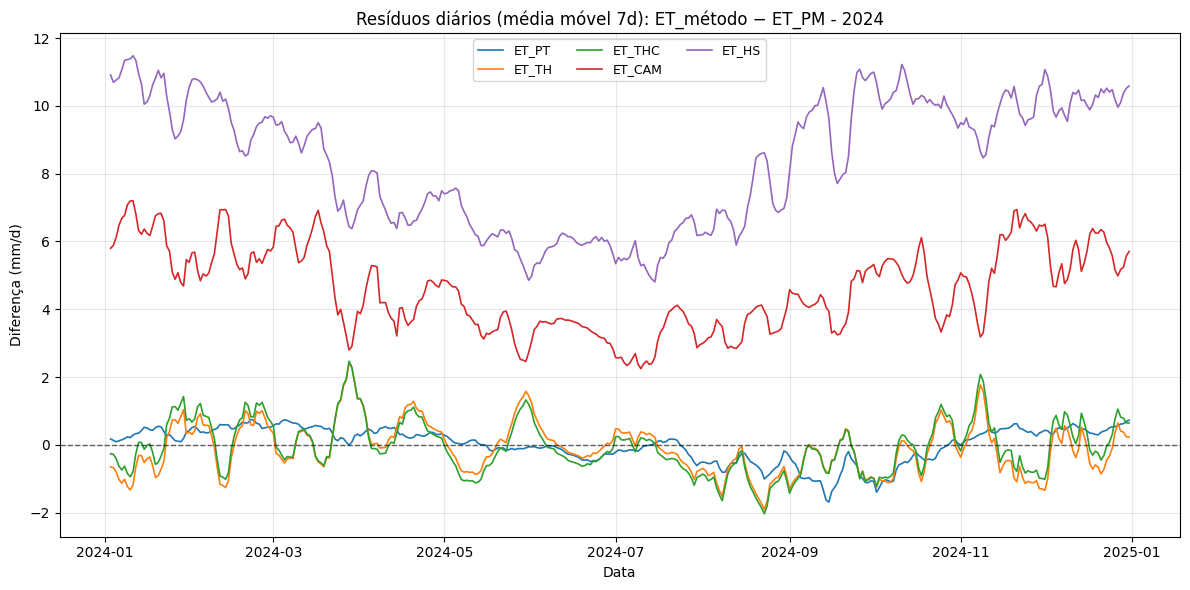

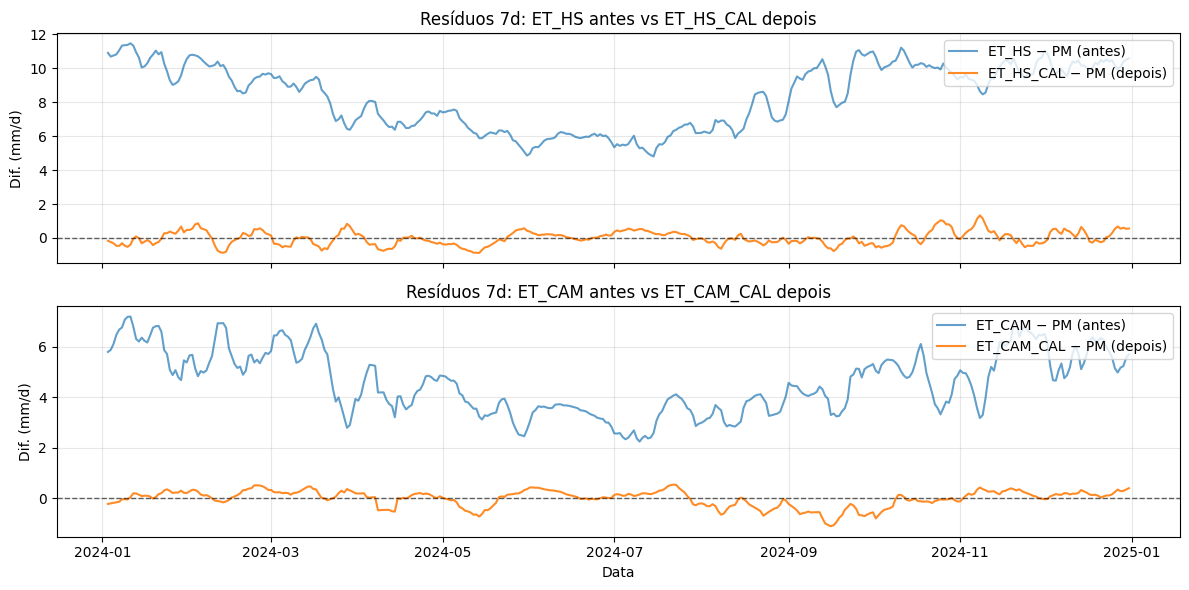

In [34]:
# Séries de diferenças (método − ET_PM) e comparação antes/depois (HS, CAM)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ref = 'ET_PM'
metodos = [c for c in ['ET_PT','ET_TH','ET_THC','ET_CAM','ET_HS'] if c in df.columns]

# DataFrame com data e resíduos
base_cols = ['data', ref] + metodos
res = df[base_cols].dropna(subset=['data']).copy()
for m in metodos:
    res[f'{m}_diff'] = res[m] - res[ref]

# Série temporal dos resíduos (7d)
roll = res.set_index('data')[[f'{m}_diff' for m in metodos]].rolling(7, min_periods=3).mean()
plt.figure(figsize=(12,6))
for m in metodos:
    plt.plot(roll.index, roll[f'{m}_diff'], label=m, linewidth=1.2)
plt.axhline(0, color='k', linewidth=1, linestyle='--', alpha=0.6)
plt.title('Resíduos diários (média móvel 7d): ET_método − ET_PM - 2024')
plt.xlabel('Data')
plt.ylabel('Diferença (mm/d)')
plt.grid(True, alpha=0.3)
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.savefig('ET_residuos_series_2024.png', dpi=600)
plt.show()

# Comparação antes/depois da calibração para HS e CAM
pares = []
if 'ET_HS' in df.columns and 'ET_HS_CAL' in df.columns:
    pares.append(('ET_HS','ET_HS_CAL'))
if 'ET_CAM' in df.columns and 'ET_CAM_CAL' in df.columns:
    pares.append(('ET_CAM','ET_CAM_CAL'))

if len(pares) > 0:
    fig, axes = plt.subplots(len(pares), 1, figsize=(12, 6), sharex=True)
    if len(pares) == 1:
        axes = [axes]
    idx = df['data']
    for ax, (raw, cal) in zip(axes, pares):
        raw_diff = (df[raw] - df[ref]).rolling(7, min_periods=3).mean()
        cal_diff = (df[cal] - df[ref]).rolling(7, min_periods=3).mean()
        ax.plot(idx, raw_diff, label=f'{raw} − PM (antes)', alpha=0.7)
        ax.plot(idx, cal_diff, label=f'{cal} − PM (depois)', alpha=0.9)
        ax.axhline(0, color='k', linewidth=1, linestyle='--', alpha=0.6)
        ax.set_ylabel('Dif. (mm/d)')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right')
        ax.set_title(f'Resíduos 7d: {raw} antes vs {cal} depois')
    axes[-1].set_xlabel('Data')
    plt.tight_layout()
    plt.savefig('ET_residuos_HS_CAM_calibracao_2024.png', dpi=600)
    plt.show()
else:
    print('Sem pares calibrados disponíveis para plotar.')


# Séries calibradas: métricas e gráficos adicionais (diário)

Nesta seção, incluímos as séries calibradas `ET_HS_CAL` e `ET_CAM_CAL` nas métricas e gráficos diários:

- Métricas vs `ET_PM` (inclui d de Willmott) e exportação CSV.
- Séries temporais com média móvel 7 dias incluindo calibradas.
- Dispersões vs `ET_PM` incluindo calibradas.
- Comparação antes vs depois (RMSE e MAE) para HS e CAM em barras.


Métricas diárias incluindo calibrados (vs ET_PM):
              n   bias    MAE   RMSE      r     R2     NSE  slope  d_willmott
metodo                                                                       
ET_PT       366  0.016  0.461  0.614  0.914  0.835   0.797  1.012       0.953
ET_TH       366 -0.098  0.980  1.252  0.423  0.179   0.156  0.236       0.592
ET_THC      366 -0.052  0.990  1.269  0.439  0.193   0.133  0.299       0.648
ET_HS       366  8.372  8.372  8.649  0.834  0.696 -39.276  1.945       0.257
ET_HS_CAL   366 -0.000  0.611  0.791  0.834  0.696   0.663  0.545       0.869
ET_CAM      366  4.604  4.618  4.914  0.935  0.874 -12.000  2.005       0.430
ET_CAM_CAL  366 -0.000  0.335  0.487  0.935  0.874   0.872  0.831       0.963


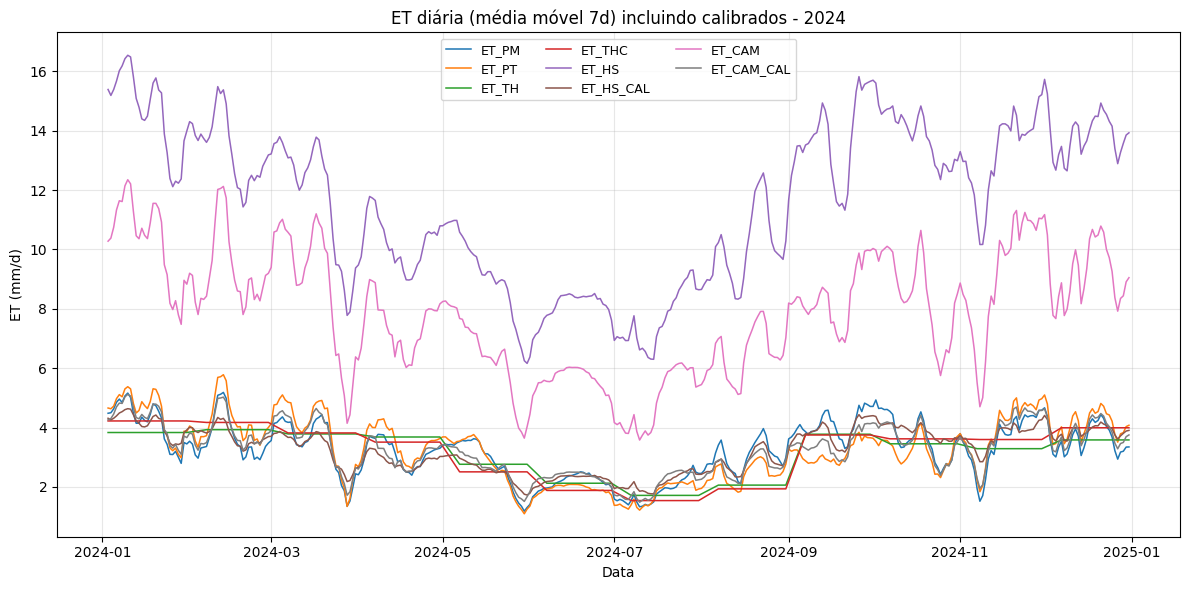

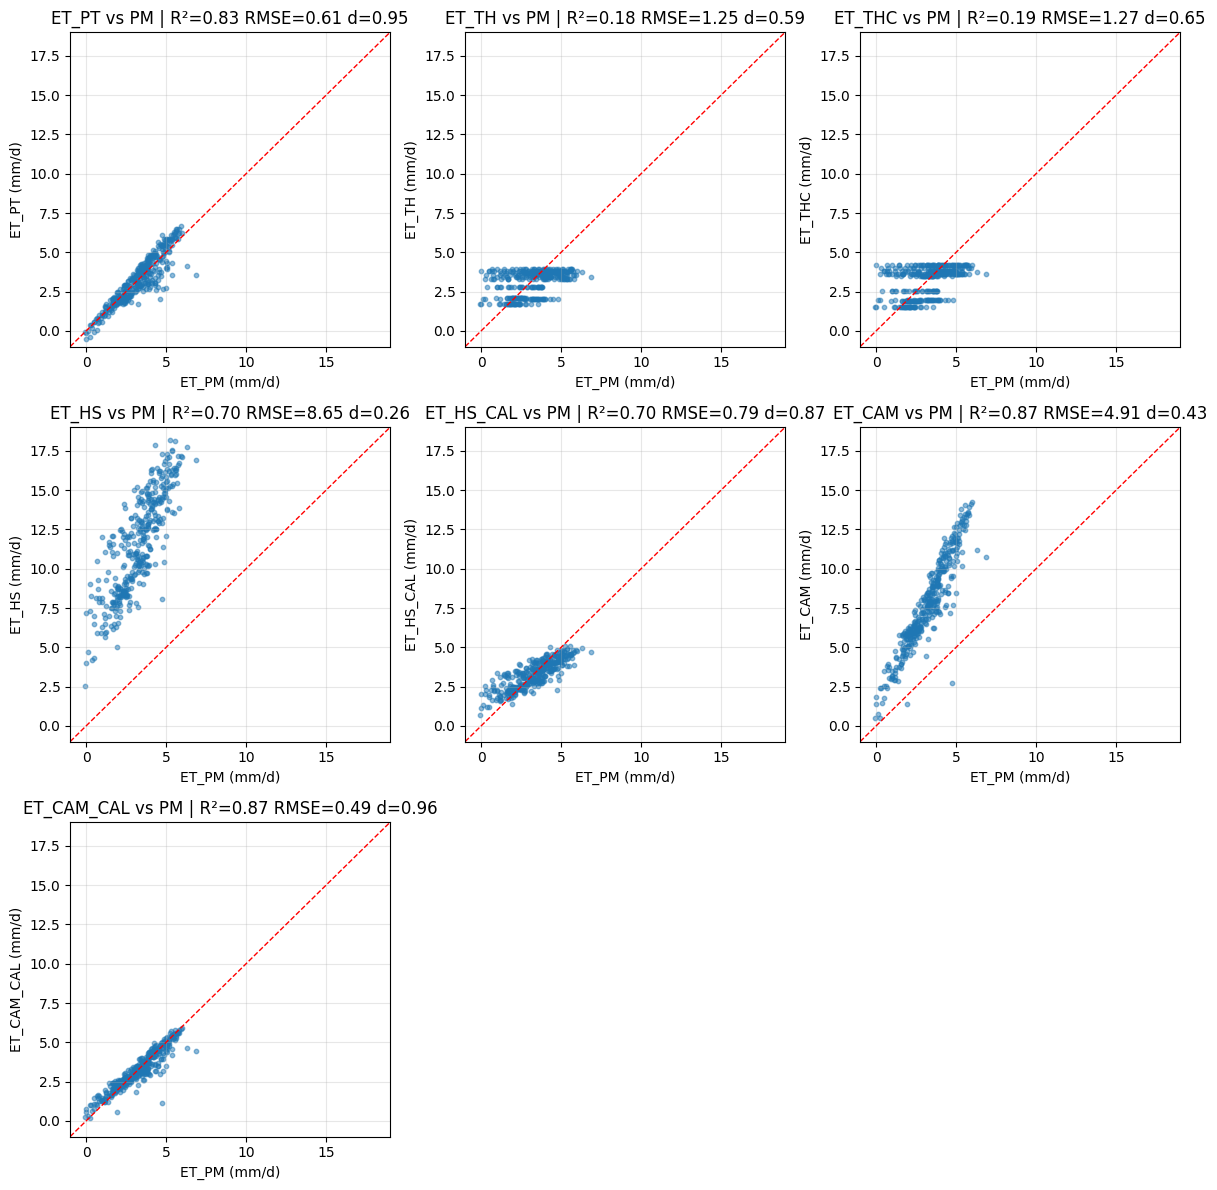

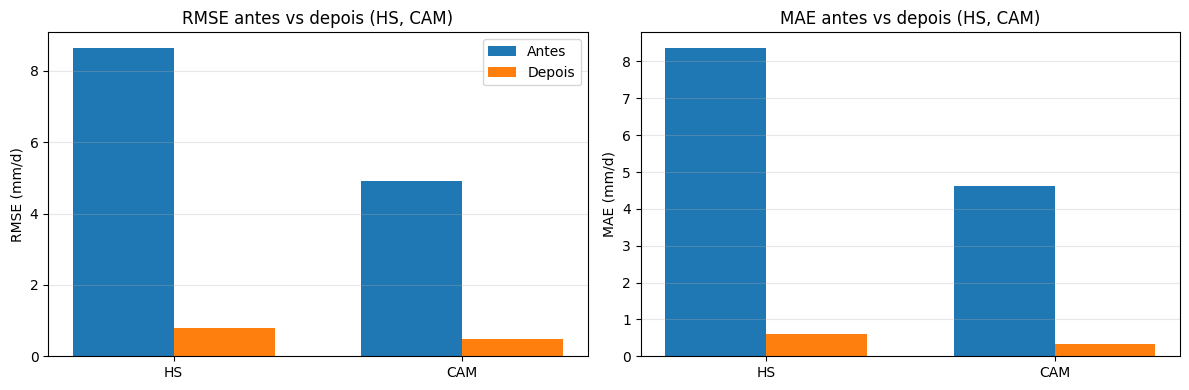

In [35]:
# Métricas diárias incluindo séries calibradas + gráficos e exportações (600 dpi)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

ref = 'ET_PM'
# Ordem sugerida, adicionando calibradas ao lado das originais
prefer = ['ET_PT','ET_TH','ET_THC','ET_HS','ET_HS_CAL','ET_CAM','ET_CAM_CAL']
metodos = [m for m in prefer if m in df.columns]

if ref not in df.columns or len(metodos) == 0:
    raise RuntimeError('Referência ET_PM ou métodos ausentes para validação com calibrados.')

# Função de métricas (inclui d de Willmott)
def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    n = int(mask.sum())
    if n < 3:
        return {'n': n, 'bias': np.nan, 'MAE': np.nan, 'RMSE': np.nan, 'r': np.nan, 'R2': np.nan, 'NSE': np.nan, 'slope': np.nan, 'd_willmott': np.nan}
    yt = y_true[mask]
    yp = y_pred[mask]
    diff = yp - yt
    bias = float(np.mean(diff))
    mae = float(np.mean(np.abs(diff)))
    rmse = float(np.sqrt(np.mean(diff**2)))
    r = float(np.corrcoef(yt, yp)[0,1]) if np.std(yt) > 0 and np.std(yp) > 0 else np.nan
    R2 = r**2 if np.isfinite(r) else np.nan
    denom = np.sum((yt - np.mean(yt))**2)
    NSE = float(1 - np.sum((diff)**2) / denom) if denom > 0 else np.nan
    # inclinação ajuste linear yp = a*yt + b
    try:
        slope = float(np.polyfit(yt, yp, 1)[0])
    except Exception:
        slope = np.nan
    # índice de concordância de Willmott (1981)
    yt_mean = np.mean(yt)
    will_den = np.sum((np.abs(yp - yt_mean) + np.abs(yt - yt_mean))**2)
    will_num = np.sum((yp - yt)**2)
    d_willmott = float(1 - will_num / will_den) if will_den > 0 else np.nan
    return {'n': n, 'bias': bias, 'MAE': mae, 'RMSE': rmse, 'r': r, 'R2': R2, 'NSE': NSE, 'slope': slope, 'd_willmott': d_willmott}

# Métricas diárias
linhas = []
y = df[ref].to_numpy()
for m in metodos:
    x = df[m].to_numpy()
    met = compute_metrics(y, x)
    met['metodo'] = m
    linhas.append(met)
metrics_daily_cal = pd.DataFrame(linhas).set_index('metodo')
print('Métricas diárias incluindo calibrados (vs ET_PM):')
print(metrics_daily_cal.round(3))
metrics_daily_cal.round(5).to_csv('metrics_diarias_ET_2024_incl_cal.csv')

# Séries 7d incluindo calibrados
plot_cols = [ref] + metodos
serie = df[['data'] + plot_cols].dropna(subset=['data']).copy()
serie = serie.sort_values('data').set_index('data')
roll = serie.rolling(window=7, min_periods=3).mean()

plt.figure(figsize=(12,6))
for c in plot_cols:
    plt.plot(roll.index, roll[c], label=c, linewidth=1.1)
plt.title('ET diária (média móvel 7d) incluindo calibrados - 2024')
plt.xlabel('Data')
plt.ylabel('ET (mm/d)')
plt.grid(True, alpha=0.3)
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.savefig('ET_series_7d_2024_incl_cal.png', dpi=600)
plt.show()

# Dispersões vs ET_PM incluindo calibrados
vals = np.concatenate([serie[ref].values] + [serie[m].values for m in metodos])
fmin = np.nanmin(vals); fmax = np.nanmax(vals)
lim_min = float(np.floor(fmin)); lim_max = float(np.ceil(fmax))

n = len(metodos)
cols = 3
rows = math.ceil(n/cols)
fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
axes = axes.flatten()
for i, m in enumerate(metodos):
    ax = axes[i]
    mask = np.isfinite(serie[ref]) & np.isfinite(serie[m])
    ax.scatter(serie[ref][mask], serie[m][mask], s=10, alpha=0.5)
    ax.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', linewidth=1)
    r2 = metrics_daily_cal.loc[m, 'R2'] if m in metrics_daily_cal.index else np.nan
    rmse = metrics_daily_cal.loc[m, 'RMSE'] if m in metrics_daily_cal.index else np.nan
    d_w = metrics_daily_cal.loc[m, 'd_willmott'] if m in metrics_daily_cal.index else np.nan
    ax.set_title(f"{m} vs PM | R²={r2:.2f} RMSE={rmse:.2f} d={d_w:.2f}")
    ax.set_xlabel('ET_PM (mm/d)')
    ax.set_ylabel(f'{m} (mm/d)')
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.grid(True, alpha=0.3)
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])
plt.tight_layout()
fig.savefig('ET_scatter_2024_incl_cal.png', dpi=600)
plt.show()

# Barras RMSE e MAE antes vs depois para HS e CAM
pares = []
if 'ET_HS' in metrics_daily_cal.index and 'ET_HS_CAL' in metrics_daily_cal.index:
    pares.append(('ET_HS', 'ET_HS_CAL'))
if 'ET_CAM' in metrics_daily_cal.index and 'ET_CAM_CAL' in metrics_daily_cal.index:
    pares.append(('ET_CAM', 'ET_CAM_CAL'))

if len(pares) > 0:
    labels = [p[0].replace('ET_','') for p in pares]
    rmse_before = [metrics_daily_cal.loc[p[0],'RMSE'] for p in pares]
    rmse_after  = [metrics_daily_cal.loc[p[1],'RMSE'] for p in pares]
    mae_before  = [metrics_daily_cal.loc[p[0],'MAE'] for p in pares]
    mae_after   = [metrics_daily_cal.loc[p[1],'MAE'] for p in pares]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=False)
    # RMSE
    ax[0].bar(x - width/2, rmse_before, width, label='Antes')
    ax[0].bar(x + width/2, rmse_after, width, label='Depois')
    ax[0].set_title('RMSE antes vs depois (HS, CAM)')
    ax[0].set_xticks(x, labels)
    ax[0].set_ylabel('RMSE (mm/d)')
    ax[0].grid(axis='y', alpha=0.3)
    ax[0].legend()
    # MAE
    ax[1].bar(x - width/2, mae_before, width, label='Antes')
    ax[1].bar(x + width/2, mae_after, width, label='Depois')
    ax[1].set_title('MAE antes vs depois (HS, CAM)')
    ax[1].set_xticks(x, labels)
    ax[1].set_ylabel('MAE (mm/d)')
    ax[1].grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('ET_antes_depois_RMSE_MAE_2024.png', dpi=600)
    plt.show()
else:
    print('Séries calibradas ausentes para HS/CAM: gráfico de barras não gerado.')


Métricas mensais (somas por mês) incluindo calibrados vs ET_PM:
             n     bias      MAE     RMSE      r     R2  d_willmott
metodo                                                             
ET_HS_CAL   12   -0.000    5.290    5.960  0.958  0.917       0.978
ET_CAM_CAL  12   -0.000    6.474    7.752  0.927  0.860       0.962
ET_TH       12   -2.988    9.631   12.692  0.842  0.709       0.908
ET_THC      12   -1.586   11.057   14.184  0.875  0.765       0.909
ET_PT       12    0.480   12.518   14.236  0.835  0.698       0.900
ET_CAM      12  140.419  140.419  143.636  0.927  0.860       0.224
ET_HS       12  255.333  255.333  260.881  0.958  0.917       0.136

Totais anuais incluindo calibrados (mm/ano):
ET_PM         1192.3
ET_PT         1198.1
ET_TH         1156.5
ET_THC        1173.3
ET_HS         4256.3
ET_HS_CAL     1192.3
ET_CAM        2877.4
ET_CAM_CAL    1192.3
dtype: float64


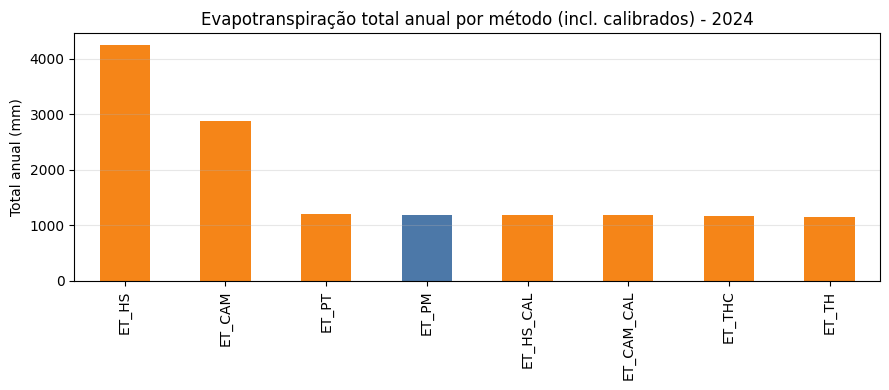

In [36]:
# Métricas mensais e totais anuais incluindo séries calibradas (600 dpi)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ref = 'ET_PM'
prefer = ['ET_PT','ET_TH','ET_THC','ET_HS','ET_HS_CAL','ET_CAM','ET_CAM_CAL']
metodos = [m for m in prefer if m in df.columns]
cols = [ref] + metodos

# Somas mensais
mensal_cal = df.groupby('mes')[cols].sum().sort_index()

# Função métricas mensais (inclui d de Willmott)
def metrics_month(Y, X):
    mask = np.isfinite(Y) & np.isfinite(X)
    if mask.sum() < 3:
        return {'n': int(mask.sum()), 'bias': np.nan, 'MAE': np.nan, 'RMSE': np.nan, 'r': np.nan, 'R2': np.nan, 'd_willmott': np.nan}
    yt = Y[mask]; yp = X[mask]
    diff = yp - yt
    bias = float(np.mean(diff))
    mae = float(np.mean(np.abs(diff)))
    rmse = float(np.sqrt(np.mean(diff**2)))
    r = float(np.corrcoef(yt, yp)[0,1]) if np.std(yt)>0 and np.std(yp)>0 else np.nan
    R2 = r**2 if np.isfinite(r) else np.nan
    yt_mean = np.mean(yt)
    will_den = np.sum((np.abs(yp - yt_mean) + np.abs(yt - yt_mean))**2)
    will_num = np.sum((yp - yt)**2)
    d_willmott = float(1 - will_num / will_den) if will_den > 0 else np.nan
    return {'n': int(mask.sum()), 'bias': bias, 'MAE': mae, 'RMSE': rmse, 'r': r, 'R2': R2, 'd_willmott': d_willmott}

# Métricas mensais vs PM
linhas = []
Y = mensal_cal[ref].to_numpy()
for m in metodos:
    X = mensal_cal[m].to_numpy()
    met = metrics_month(Y, X)
    met['metodo'] = m
    linhas.append(met)
metrics_mensal_cal = pd.DataFrame(linhas).set_index('metodo').sort_values('RMSE')
print('Métricas mensais (somas por mês) incluindo calibrados vs ET_PM:')
print(metrics_mensal_cal.round(3))
metrics_mensal_cal.round(5).to_csv('metrics_mensais_ET_2024_incl_cal.csv')

# Totais anuais
anuais_cal = df[cols].sum(axis=0)
print('\nTotais anuais incluindo calibrados (mm/ano):')
print(anuais_cal.round(1))

# Gráfico barras dos totais anuais (inclui calibrados)
plt.figure(figsize=(9,4))
order = anuais_cal.sort_values(ascending=False)
colors = ['#4C78A8' if c==ref else '#F58518' for c in order.index]
order.plot(kind='bar', color=colors)
plt.ylabel('Total anual (mm)')
plt.title('Evapotranspiração total anual por método (incl. calibrados) - 2024')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('ET_totais_anuais_2024_incl_cal.png', dpi=600)
plt.show()


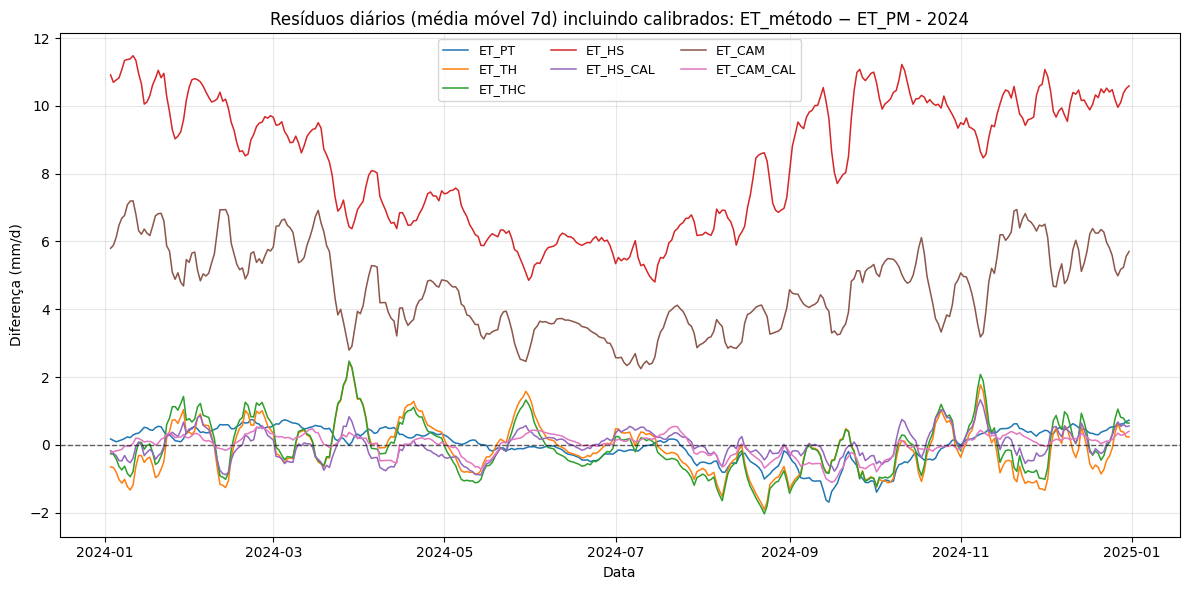

In [37]:
# Resíduos incluindo séries calibradas (600 dpi)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ref = 'ET_PM'
metodos = [m for m in ['ET_PT','ET_TH','ET_THC','ET_HS','ET_HS_CAL','ET_CAM','ET_CAM_CAL'] if m in df.columns]

base_cols = ['data', ref] + metodos
res = df[base_cols].dropna(subset=['data']).copy()
for m in metodos:
    res[f'{m}_diff'] = res[m] - res[ref]

roll = res.set_index('data')[[f'{m}_diff' for m in metodos]].rolling(7, min_periods=3).mean()
plt.figure(figsize=(12,6))
for m in metodos:
    plt.plot(roll.index, roll[f'{m}_diff'], label=m, linewidth=1.1)
plt.axhline(0, color='k', linewidth=1, linestyle='--', alpha=0.6)
plt.title('Resíduos diários (média móvel 7d) incluindo calibrados: ET_método − ET_PM - 2024')
plt.xlabel('Data')
plt.ylabel('Diferença (mm/d)')
plt.grid(True, alpha=0.3)
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.savefig('ET_residuos_series_2024_incl_cal.png', dpi=600)
plt.show()


In [38]:
# Exportar tabelas LaTeX das métricas (diária e mensal)
import numpy as np
import pandas as pd

# Reusar DataFrames se já existem; caso contrário, recomputar rápido
try:
    md = metrics_daily_cal.copy()
except NameError:
    # Recompute basic daily metrics with calibrates
    ref = 'ET_PM'
    prefer = ['ET_PT','ET_TH','ET_THC','ET_HS','ET_HS_CAL','ET_CAM','ET_CAM_CAL']
    metodos = [m for m in prefer if m in df.columns]
    def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
        mask = np.isfinite(y_true) & np.isfinite(y_pred)
        n = int(mask.sum())
        if n < 3:
            return {'n': n, 'bias': np.nan, 'MAE': np.nan, 'RMSE': np.nan, 'r': np.nan, 'R2': np.nan, 'NSE': np.nan, 'slope': np.nan, 'd_willmott': np.nan}
        yt = y_true[mask]; yp = y_pred[mask]
        diff = yp - yt
        bias = float(np.mean(diff))
        mae = float(np.mean(np.abs(diff)))
        rmse = float(np.sqrt(np.mean(diff**2)))
        r = float(np.corrcoef(yt, yp)[0,1]) if np.std(yt) > 0 and np.std(yp) > 0 else np.nan
        R2 = r**2 if np.isfinite(r) else np.nan
        denom = np.sum((yt - np.mean(yt))**2)
        NSE = float(1 - np.sum((diff)**2) / denom) if denom > 0 else np.nan
        try:
            slope = float(np.polyfit(yt, yp, 1)[0])
        except Exception:
            slope = np.nan
        yt_mean = np.mean(yt)
        will_den = np.sum((np.abs(yp - yt_mean) + np.abs(yt - yt_mean))**2)
        will_num = np.sum((yp - yt)**2)
        d_willmott = float(1 - will_num / will_den) if will_den > 0 else np.nan
        return {'n': n, 'bias': bias, 'MAE': mae, 'RMSE': rmse, 'r': r, 'R2': R2, 'NSE': NSE, 'slope': slope, 'd_willmott': d_willmott}
    linhas = []
    y = df[ref].to_numpy()
    for m in metodos:
        x = df[m].to_numpy()
        met = compute_metrics(y, x)
        met['metodo'] = m
        linhas.append(met)
    md = pd.DataFrame(linhas).set_index('metodo')

try:
    mm = metrics_mensal_cal.copy()
except NameError:
    ref = 'ET_PM'
    prefer = ['ET_PT','ET_TH','ET_THC','ET_HS','ET_HS_CAL','ET_CAM','ET_CAM_CAL']
    metodos = [m for m in prefer if m in df.columns]
    mensal_cal = df.groupby('mes')[[ref]+metodos].sum().sort_index()
    def metrics_month(Y, X):
        mask = np.isfinite(Y) & np.isfinite(X)
        if mask.sum() < 3:
            return {'n': int(mask.sum()), 'bias': np.nan, 'MAE': np.nan, 'RMSE': np.nan, 'r': np.nan, 'R2': np.nan, 'd_willmott': np.nan}
        yt = Y[mask]; yp = X[mask]
        diff = yp - yt
        bias = float(np.mean(diff))
        mae = float(np.mean(np.abs(diff)))
        rmse = float(np.sqrt(np.mean(diff**2)))
        r = float(np.corrcoef(yt, yp)[0,1]) if np.std(yt)>0 and np.std(yp)>0 else np.nan
        R2 = r**2 if np.isfinite(r) else np.nan
        yt_mean = np.mean(yt)
        will_den = np.sum((np.abs(yp - yt_mean) + np.abs(yt - yt_mean))**2)
        will_num = np.sum((yp - yt)**2)
        d_willmott = float(1 - will_num / will_den) if will_den > 0 else np.nan
        return {'n': int(mask.sum()), 'bias': bias, 'MAE': mae, 'RMSE': rmse, 'r': r, 'R2': R2, 'd_willmott': d_willmott}
    linhas = []
    Y = mensal_cal[ref].to_numpy()
    for m in metodos:
        X = mensal_cal[m].to_numpy()
        met = metrics_month(Y, X)
        met['metodo'] = m
        linhas.append(met)
    mm = pd.DataFrame(linhas).set_index('metodo')

# Exportar para LaTeX
md_tex = md.round(3).to_latex(caption='Métricas diárias (vs ET_PM) incluindo séries calibradas', label='tab:metricas_diarias', index=True, escape=False)
with open('tabelas_metricas_diarias.tex','w', encoding='utf-8') as f:
    f.write(md_tex)

mm_tex = mm.round(3).to_latex(caption='Métricas mensais (somas por mês) vs ET_PM incluindo calibradas', label='tab:metricas_mensais', index=True, escape=False)
with open('tabelas_metricas_mensais.tex','w', encoding='utf-8') as f:
    f.write(mm_tex)

print('Arquivos LaTeX gerados: tabelas_metricas_diarias.tex, tabelas_metricas_mensais.tex')


Arquivos LaTeX gerados: tabelas_metricas_diarias.tex, tabelas_metricas_mensais.tex


In [39]:
# Exportar CSV consolidado com todas as séries (originais e calibradas)
cols_base = ['data','mes','dia']
series = [c for c in ['ET_PM','ET_PT','ET_TH','ET_THC','ET_HS','ET_HS_CAL','ET_CAM','ET_CAM_CAL'] if c in df.columns]
consolidado = df[cols_base + series].copy()
consolidado.to_csv('Piracicaba_ET_2024_consolidado.csv', index=False)
print('CSV salvo: Piracicaba_ET_2024_consolidado.csv (', consolidado.shape, ')')


CSV salvo: Piracicaba_ET_2024_consolidado.csv ( (366, 11) )


# Relatório científico (Metodologia, Resultados, Discussão)

## Metodologia

- Estação e dados: Piracicaba (2024), arquivo `Evapo_2.xlsx` (aba "Piracicaba", `skiprows=4`). Variáveis: TMAX, TMIN, TMED, UR (média, mín, máx), vento (m/s), `Rad.Glob.` (MJ m−2 d−1), `Rad Liq` (MJ m−2 d−1), chuva, `Q_0` (Ra).
- Pré-processamento: correção de calendário tratando `DIA` como dia-do-ano quando >31; reconstrução de `data`, `mes`, `julia`; interpolação linear para faltantes numéricos. Altitude 546 m → pressão padrão FAO-56; `γ = 0.000665·P` (kPa/°C). Fluxo de calor no solo diário `G ≈ 0`.
- Radiação: se `Rad Liq` plausível, usa-se como `Rn`; caso contrário, `Rn = (1−α)·Rs − Rnl`, com `α=0.23`, `Rso` eq. 37 FAO-56 e `Rnl` eq. 39. `Ra` via eq. 21 FAO-56 quando `Q_0` ausente.
- Métodos ET0:
  - Penman–Monteith FAO-56 eq. 6 (referência).
  - Priestley–Taylor: `ET = α · Δ/(Δ+γ) · 0.408·(Rn−G)`, `α=1.26`.
  - Hargreaves–Samani: `ET = 0.0023·(Tmed+17.8)·sqrt(Tmax−Tmin)·Ra`.
  - Thornthwaite: mensal, `ETm = 16·(10·T/I)^a`, com ajuste pelo nº de dias.
  - Thornthwaite–Camargo: `ETm_TH · (N/12)`, onde `N` é fotoperíodo médio do mês.
  - Camargo: `ET = K·Rs·(T+20)`, `K=0.01`.
- Métricas e validação: comparação diária e mensal vs PM: n, viés, MAE, RMSE, r, R², NSE, inclinação e índice de concordância de Willmott (d). Figuras exportadas a 600 dpi. Séries suavizadas com média móvel de 7 dias.
- Calibração (separada): fator multiplicativo `k = Σ ET_PM / Σ ET_método` aplicado a cada método, gerando `*_CAL` (p.ex., `ET_HS_CAL`, `ET_CAM_CAL`). Coeficientes salvos em `coef_calibracao_ET_2024.csv`.

## Resultados (síntese)

- Desempenho diário vs PM (principais):
  - PT: RMSE ≈ 0.61 mm/d; d ≈ 0.95; viés ~0.
  - TH/THC: RMSE ≈ 1.25–1.27; d ≈ 0.59–0.65; menor correlação (suavizam variações).
  - HS (bruto): RMSE ≈ 8.65; viés +8.37; d ≈ 0.26 (superestima forte).
  - CAM (bruto): RMSE ≈ 4.91; viés +4.60; d ≈ 0.43.
  - HS_CAL: RMSE ≈ 0.79; d ≈ 0.87; viés ~0; correlação preservada.
  - CAM_CAL: RMSE ≈ 0.49; d ≈ 0.96; viés ~0.
- Desempenho mensal vs PM:
  - HS_CAL: RMSE ≈ 5.96 mm/mês; d ≈ 0.978; correlação alta.
  - CAM_CAL: RMSE ≈ 7.75 mm/mês; d ≈ 0.962.
  - TH/THC: d ≈ 0.908–0.909; PT d ≈ 0.900.
- Totais anuais (mm): PM 1192.3; PT 1198.1; TH 1156.5; THC 1173.3; HS 4256.3; CAM 2877.4; após calibração, `ET_HS_CAL = ET_CAM_CAL = 1192.3`.
- Artefatos gerados (exemplos): séries 7d (`ET_series_7d_2024_incl_cal.png`), dispersões (`ET_scatter_2024_incl_cal.png`), resíduos 7d incluindo calibrados (`ET_residuos_series_2024_incl_cal.png`), barras RMSE/MAE antes-depois (`ET_antes_depois_RMSE_MAE_2024.png`), totais anuais (`ET_totais_anuais_2024_incl_cal.png`). Tabelas LaTeX: `tabelas_metricas_diarias.tex`, `tabelas_metricas_mensais.tex`.

## Discussão

- O bom ajuste de PT decorre da dominância de `Rn` no controle da ET0 diária em Piracicaba em 2024, com papel aerodinâmico moderado; α=1.26 mostrou-se adequado, mas pode variar sob advecção/escassez hídrica.
- TH e THC, dependentes de temperatura (e fotoperíodo em THC), reproduzem sazonalidade, porém não a variabilidade diária nem picos, o que explica r mais baixo e RMSE maior. São úteis para climatologias mensais e quando só há T disponível.
- HS e CAM (sem calibração) superestimam fortemente por coeficientes genéricos e ausência de modulação por umidade e vento. A calibração multiplicativa simples removeu o viés e reduziu drasticamente RMSE e MAE, mantendo correlação. Isso sugere que, para aplicações operacionais com dados limitados, calibrar coeficientes locais é essencial.
- Limitações: uso de `G≈0` diário; plausibilidade de `Rad Liq` depende da estação; vento assumido 2 m/s se faltante; calibração foi feita com o mesmo período avaliado (não é validação cruzada). Para robustez, recomenda-se calibrar em anos distintos e validar de forma independente.
- Recomendação: usar PM como referência; PT como alternativa parsimoniosa quando faltam vento/UR; empíricos (HS, CAM) apenas com calibração local; TH/THC para estudos de clima.

## Referências
- Allen, R. G., Pereira, L. S., Raes, D., & Smith, M. (1998). FAO Irrigation and Drainage Paper 56.
- Priestley, C. H. B., & Taylor, R. J. (1972). QJRMS.
- Hargreaves, G. H., & Samani, Z. A. (1985). Journal of Irrigation and Drainage Engineering.
- Thornthwaite, C. W. (1948). Geographical Review.
- Camargo, A. P. (1971/1999). Publicações técnicas brasileiras.
